<a href="https://colab.research.google.com/github/xxxcrttt/SQL/blob/main/sps_lecture3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ipympl

In [ ]:
import numpy as np
import torch as t
import matplotlib.pyplot as plt
%matplotlib widget
from ipywidgets import FloatSlider, IntSlider, interact, interact_manual
from torch.distributions import Bernoulli
from torch.distributions import MultivariateNormal as MvNormal

# Lecture 3
## Bayesian inference for unsupervised learning 

### Simple example: A biased coin flip 

This is a Bernoulli distribution with probability $p$ -- a biased coin flip.

In [ ]:
def sample_bernoulli(p):
  return Bernoulli(probs=p).sample((10,))

interact_manual(sample_bernoulli, p=FloatSlider(value=0.5, min=0, max=1, step=0.05));
 

interactive(children=(FloatSlider(value=0.5, description='p', max=1.0, step=0.05), Button(description='Run Int…

compute the probability of a sample, under this distribution. $x$ is distributed according to a Bernoulli:

\begin{align}
P(x| p) = Bernoulli(x; p)
\end{align}

where: 

\begin{align}
Bernoulli(x;p) = \begin{cases} 1-p &\text{ if } x=0 \\ p &\text{ if } x=1 \end{cases}
\end{align}

Thus we can evaluate the probability of a sample (0. or 1.) under a Bernoulli.


#### Maximum Likelihood Fitting of a Bernoulli 

In [ ]:
# specifying the data 
xs = t.tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.])
xs.shape

torch.Size([12])

The likelihood, is the probability of all the data, treated as a function of the parameter, $p$, is:

\begin{align}
  P(x| p) = \prod_\lambda P(x_\lambda| p)
\end{align}

log-likelihood:   
is considered a function of the parameters(s), $p$, but not the data, which is considered fixed. 

\begin{align}
  L(p) = \sum_\lambda \log P(x_\lambda| p)
\end{align}

The goal is to fine $\hat p$ which maximizes $L(p)$:

\begin{align}
  \hat p = argmax_{p} L(p)
\end{align}

In [ ]:
def log_likelihood(p):
  return Bernoulli(probs=p).log_prob(xs).sum(-1, keepdim=True)
  
interact(log_likelihood, p=FloatSlider(min=0.01, max=0.99, step=0.01));
 

interactive(children=(FloatSlider(value=0.01, description='p', max=0.99, min=0.01, step=0.01), Output()), _dom…

In [ ]:
# Plot the log_likelihood
ps = t.linspace(0.01, 0.99, 99)[:,None]
print(ps.shape)
ps[:6, :]

torch.Size([99, 1])


tensor([[0.0100],
        [0.0200],
        [0.0300],
        [0.0400],
        [0.0500],
        [0.0600]])

In [ ]:
lls = log_likelihood(ps)
lls.shape

torch.Size([99, 1])

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()

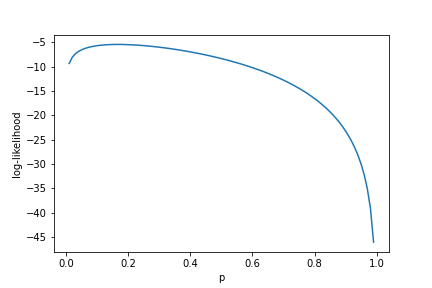

In [ ]:
fig, ax = plt.subplots()
ax.set_xlabel("p")
ax.set_ylabel("log-likelihood")
ax.plot(ps, lls);

With many more parameters -- other way!

1. Try to find an analytic expression for the $p$ with the maximal log-probabilty:

\begin{align}
  L(p) &= \sum_\lambda \log P(x_\lambda| p)\\
  L(p) &= (\sum_\lambda x_\lambda) \log p + (N - \sum_\lambda x_\lambda) \log (1-p)
\end{align}

Solve for where the gradient is 0: 


\dfrac{\partial f}{\partial x}


\begin{align}
  0 &= \at \dfrac{\partial L(p)} {∂ p}_{p=\hat{p}}\\
  0 &= \dfrac{\sum_\lambda x_\lambda}{\hat{p}} - \frac{N - \sum_\lambda x_\lambda}{1-\hat{p}}\\
  \frac{\sum_\lambda x_\lambda}{\hat{p}} &= \frac{N - \sum_\lambda x_\lambda}{1-\hat{p}}\\
  (1-\hat{p}) \sum_\lambda x_\lambda &= \hat{p} ({N - \sum_\lambda x_\lambda})\\
  \sum_\lambda x_\lambda &= \hat{p} N\\
  \hat{p} &= \tfrac{1}{N} \sum_i x_i
\end{align}

The maximum-likelihood probability is the empirical mean of the data points. 

Under this derivation, we can write a function that automatically fits a Bernoulli distribution.



In [ ]:
def fit_bernoulli(xs):
  p = xs.sum() / xs.shape[-1]
  return Bernoulli(probs=p)

fitted_bernoulli = fit_bernoulli(xs)

In [ ]:
# such that samples from the fitted Bernoulli look like the data
xs

tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.])

In [ ]:
fitted_bernoulli.sample((12,))

tensor([1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1.])

#### Bayesian fitting of a Bernoulli
-- when we have vey little data

the probabilities are drawn from  a uniform distribution: 

\begin{align}
  P(p) &= Uniform(p; 0, 1)
\end{align}

Start by drawing a large number of $p$s, from the uniform prior:

the value on the x-axis are *probability densities*, not probabilities

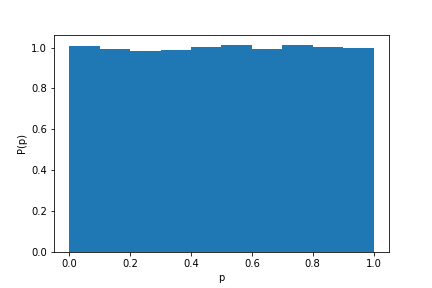

In [ ]:
N = 10**5
ps = t.rand(N)
fig, ax = plt.subplots()
ax.set_xlabel("p")
ax.set_ylabel("P(p)")
ax.hist(ps, density=True);

The probability of being in any given bin is: 

\begin{align}
  \int_{p_0}^{p_0 + \delta} dp \; P(p) \approx \delta P(p)
\end{align}

which is the bin-width times the probability density. 

Here we have 20 bins, with the probability density 1, and bin width $\delta = 1/20$.

The probability of being in any 1 bin is therefore $P(p) \times \delta = 1 \times 1/20 = 1/20$

In [ ]:
xs = Bernoulli(ps).sample((2,))
xs
xs.shape

torch.Size([2, 100000])

In [ ]:
# filter out only those values of p which actually gives 2 zeros
all_zeros = (xs==0.).all(0)
print(all_zeros)
print(all_zeros.sum())
ps_all_zeros = ps[all_zeros]
print(ps_all_zeros.shape)

tensor([False,  True,  True,  ..., False, False, False])
tensor(33270)
torch.Size([33270])


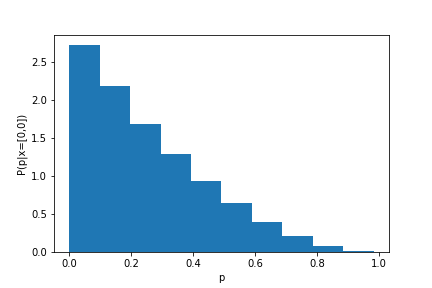

In [ ]:
# plot those p's
fig, ax = plt.subplots()
ax.set_xlabel("p")
ax.set_ylabel("P(p|x=[0,0])")
ax.hist(ps_all_zeros, density=True);